# Install these packages for cat boost

In [ ]:
# clone the dataset from git hub (tensorflow download wasn't working)
git clone https://github.com/spMohanty/PlantVillage-Dataset
cd PlantVillage-Dataset


In [ ]:
!pip install numpy==1.24.4
!pip install --upgrade --force-reinstall thinc
!pip install catboost

  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 9.1.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
blis 1.0.2 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.2.1 requires

  Using cached thinc-9.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached blis-1.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached murmurhash-1.0.12-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached cymem-2.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.5 kB)
  Using cached preshed-3.0.9-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached numpy-2.2.4-cp3

#**SVM USING SEGMENTED IMAGES**

In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

def extract_image_features(img, size=64):
    gray = cv2.resize(img, (size, size))
    if len(gray.shape) == 3:
        gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

    # edge detection
    edges = cv2.Canny(gray, 100, 200)
    edge_count = np.sum(edges > 0)
    edge_density = edge_count / (size * size)
    edge_density_log = np.log1p(edge_density)

    # GLCM features
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # intensity stats
    mean_gray = np.mean(gray)
    std_gray = np.std(gray)
    entropy = shannon_entropy(gray)

    # shape features
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = w / h if h else 0
        extent = area / (w * h) if w * h else 0
    else:
        area = perimeter = aspect_ratio = extent = 0

    # feature engineering
    contrast_ratio = contrast / mean_gray if mean_gray else 0
    normalized_entropy = entropy / mean_gray if mean_gray else 0
    extent_ratio = extent / aspect_ratio if aspect_ratio else 0
    std_to_mean_gray_ratio = std_gray / mean_gray if mean_gray else 0

    return np.array([
        mean_gray, std_gray, entropy,
        edge_density, edge_density_log,
        contrast, contrast_ratio,
        homogeneity, correlation,
        area, perimeter, aspect_ratio, extent, extent_ratio,
        std_to_mean_gray_ratio, normalized_entropy
    ])


In [ ]:
# load segmented images
data_dir = '/content/PlantVillage-Dataset/raw/segmented'  # segmented directory
X = []
y = []

for folder in os.listdir(data_dir):
    is_healthy = 'healthy' in folder.lower()
    label = 0 if is_healthy else 1  # binary classification for healthy and diseased
    folder_path = os.path.join(data_dir, folder)

    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path)[:50]:  # sample
            image_path = os.path.join(folder_path, image_file)
            try:
                # pass image through extract features
                features = extract_image_features(cv2.imread(image_path))
                X.append(features)
                y.append(label)
            except Exception as e:# Print the error to see what went wrong
                continue
# convert to array for useability
X = np.array(X)
y = np.array(y)

In [ ]:
# scale features using standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# PCA for 2D visualization - faster modeling
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



In [ ]:
# svm
clf = SVC(kernel='rbf', C=1, gamma='scale')
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

# classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Healthy", "Diseased"]))



Accuracy: 0.7394736842105263
              precision    recall  f1-score   support

     Healthy       0.65      0.38      0.48       120
    Diseased       0.76      0.91      0.83       260

    accuracy                           0.74       380
   macro avg       0.71      0.64      0.65       380
weighted avg       0.73      0.74      0.72       380



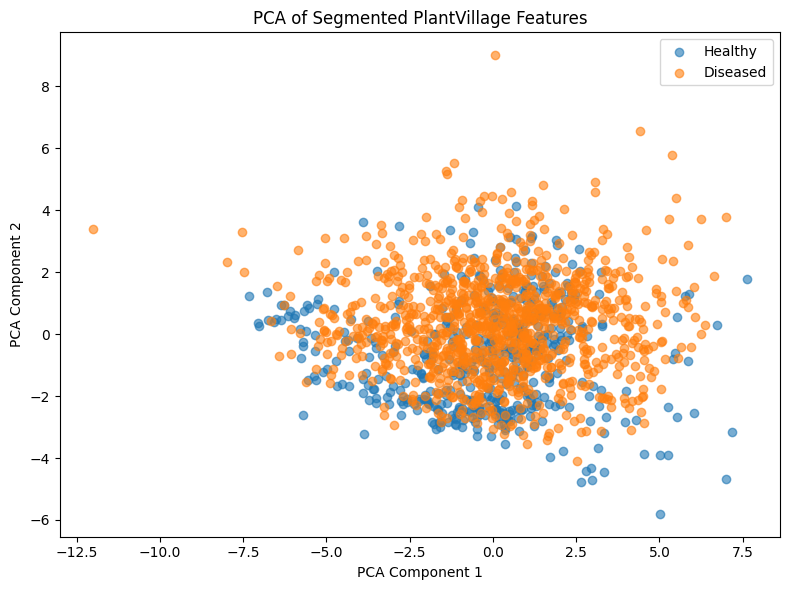

In [ ]:
# PCA plot
plt.figure(figsize=(8, 6))
for label_val, label_name in zip([0, 1], ["Healthy", "Diseased"]):
    idxs = np.where(np.array(y_train) == label_val)
    plt.scatter(X_train_pca[idxs, 0], X_train_pca[idxs, 1], label=label_name, alpha=0.6)

plt.title("PCA of Segmented PlantVillage Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.tight_layout()
plt.show()

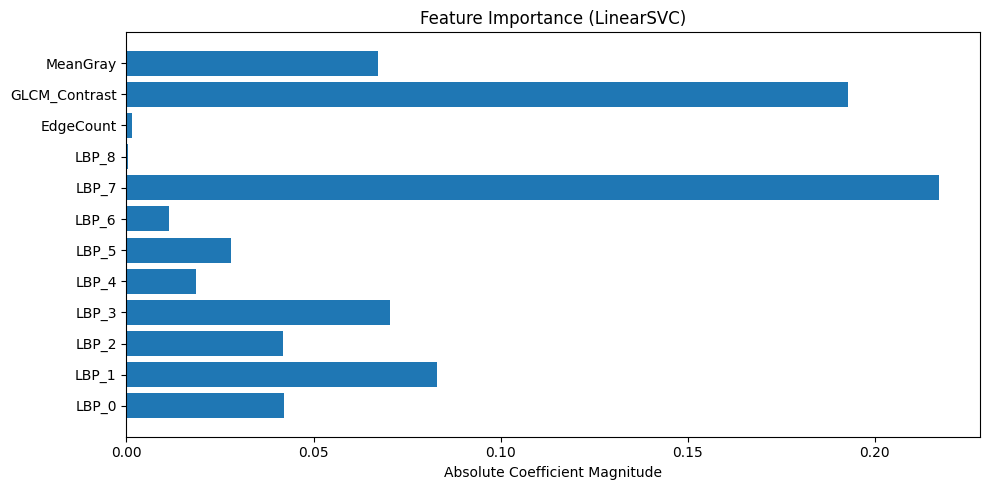

In [ ]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

# train a linear svm model to explore feature importance
clf_linear = LinearSVC(max_iter=10000)
clf_linear.fit(X_train, y_train)

# importance coefficients
importances = np.abs(clf_linear.coef_[0])
feature_names = [f"LBP_{i}" for i in range(len(importances) - 3)] + ["EdgeCount", "GLCM_Contrast", "MeanGray"]

# visualize
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.title("Feature Importance (LinearSVC)")
plt.xlabel("Absolute Coefficient Magnitude")
plt.tight_layout()
plt.show()


#**KNN USING GRAYSCALE IMAGES**

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# grayscale images
data_dir = "/content/PlantVillage-Dataset/raw/grayscale"
image_size = 64  # resize to 64x64 to reduce complexity

# load images and labels
X = []
y = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    is_healthy = 'healthy' in folder.lower()
    label = 0 if is_healthy else 1

    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".png")):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (image_size, image_size))
                features = img_resized.flatten()
                X.append(features)
                y.append(label)

# convert to arrays for useability
X = np.array(X)
y = np.array(y)

In [ ]:
# encode cats
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# reduce components for faster modeling
pca = PCA(n_components=100)  # Reduce to 100 components
X_pca = pca.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)



In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Healthy', 'Diseased'])) # Changed target_names to explicit string labels

Accuracy: 0.8597735015191972

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.74      0.76      0.75      3007
    Diseased       0.91      0.90      0.90      7854

    accuracy                           0.86     10861
   macro avg       0.82      0.83      0.83     10861
weighted avg       0.86      0.86      0.86     10861



#**DECISION TREES USING COLOR IMAGES**

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

# color images
data_dir = "/content/PlantVillage-Dataset/raw/color"
image_size = 64

X = []
y = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    is_healthy = 'healthy' in folder.lower()
    label = 0 if is_healthy else 1

    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".png")):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (image_size, image_size))

                # flatten color image (to 12288 features)
                img_flat = img_resized.flatten()

                # computing a histogram for observing how color changes on leaves
                hist_r = cv2.calcHist([img_resized], [0], None, [32], [0, 256]).flatten()
                hist_g = cv2.calcHist([img_resized], [1], None, [32], [0, 256]).flatten()
                hist_b = cv2.calcHist([img_resized], [2], None, [32], [0, 256]).flatten()
                hist_rgb = np.hstack([hist_r, hist_g, hist_b])
                hist_rgb /= hist_rgb.sum()  # normalize

                # Combine raw + histogram features
                features = np.hstack([img_flat, hist_rgb])
                X.append(features)
                y.append(label)

X = np.array(X)
y = np.array(y)



In [ ]:
# PCA
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)



In [ ]:
# decision tree
tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

# classification report
y_pred = tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Healthy", "Diseased"]))

Accuracy: 0.8570113249240402

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.77      0.69      0.73      3007
    Diseased       0.89      0.92      0.90      7854

    accuracy                           0.86     10861
   macro avg       0.83      0.81      0.82     10861
weighted avg       0.85      0.86      0.85     10861



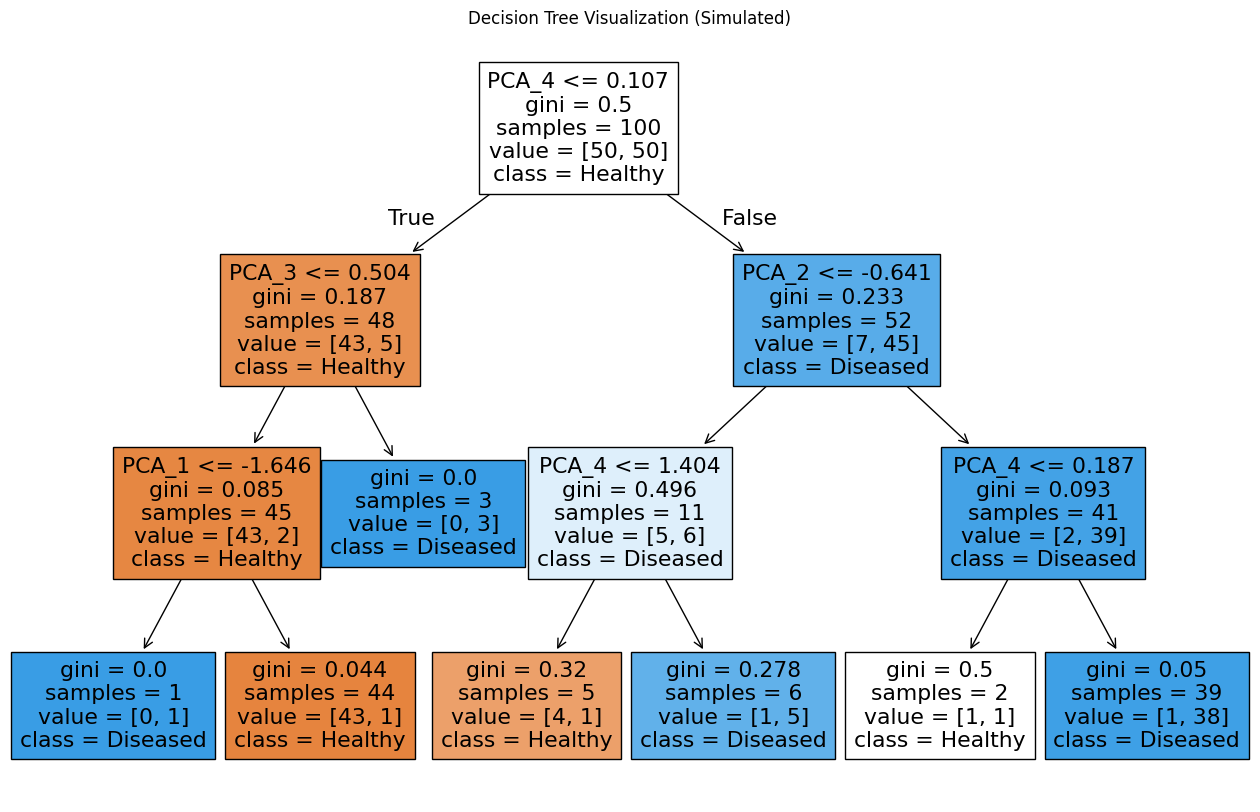

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# simulation for decision tree

# small synthetic dataset for visualization
from sklearn.datasets import make_classification
X_vis, y_vis = make_classification(n_samples=100, n_features=5, n_informative=3, n_classes=2, random_state=42)

# smaller depth for decision tree
tree_vis = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_vis.fit(X_vis, y_vis)

# plot decision tree
plt.figure(figsize=(16, 10))
plot_tree(tree_vis, filled=True, feature_names=[f"PCA_{i+1}" for i in range(X_vis.shape[1])], class_names=["Healthy", "Diseased"])
plt.title("Decision Tree Visualization (Simulated)")
plt.show()


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


# initialize CatBoost
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

# model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# classification report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Healthy", "Diseased"]))


0:	learn: 0.7401316	test: 0.7105263	best: 0.7105263 (0)	total: 2.96ms	remaining: 885ms
100:	learn: 0.9184211	test: 0.7710526	best: 0.7763158 (97)	total: 194ms	remaining: 382ms
200:	learn: 0.9835526	test: 0.7631579	best: 0.7789474 (129)	total: 382ms	remaining: 188ms
299:	learn: 0.9993421	test: 0.7710526	best: 0.7789474 (129)	total: 570ms	remaining: 0us

bestTest = 0.7789473684
bestIteration = 129

Shrink model to first 130 iterations.
Accuracy: 0.7789473684210526
              precision    recall  f1-score   support

     Healthy       0.69      0.55      0.61       120
    Diseased       0.81      0.88      0.85       260

    accuracy                           0.78       380
   macro avg       0.75      0.72      0.73       380
weighted avg       0.77      0.78      0.77       380



In [ ]:
from catboost import CatBoostClassifier
# SMOTE to training data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

cat_model = CatBoostClassifier(verbose=100)
cat_model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test))


Learning rate set to 0.037973
0:	learn: 0.6815018	test: 0.6840449	best: 0.6840449 (0)	total: 2.29ms	remaining: 2.29s
100:	learn: 0.3924941	test: 0.5234274	best: 0.5234274 (100)	total: 203ms	remaining: 1.8s
200:	learn: 0.3022604	test: 0.5058293	best: 0.5058293 (200)	total: 404ms	remaining: 1.61s
300:	learn: 0.2344198	test: 0.4943536	best: 0.4940391 (283)	total: 605ms	remaining: 1.41s
400:	learn: 0.1822544	test: 0.4904942	best: 0.4883670 (375)	total: 806ms	remaining: 1.2s
500:	learn: 0.1442944	test: 0.4932879	best: 0.4883670 (375)	total: 1.01s	remaining: 1s
600:	learn: 0.1162717	test: 0.4969451	best: 0.4883670 (375)	total: 1.21s	remaining: 805ms
700:	learn: 0.0958750	test: 0.5045462	best: 0.4883670 (375)	total: 1.41s	remaining: 603ms
800:	learn: 0.0786357	test: 0.5093543	best: 0.4883670 (375)	total: 1.62s	remaining: 402ms
900:	learn: 0.0664348	test: 0.5166731	best: 0.4883670 (375)	total: 1.82s	remaining: 200ms
999:	learn: 0.0560743	test: 0.5229660	best: 0.4883670 (375)	total: 2.02s	remai

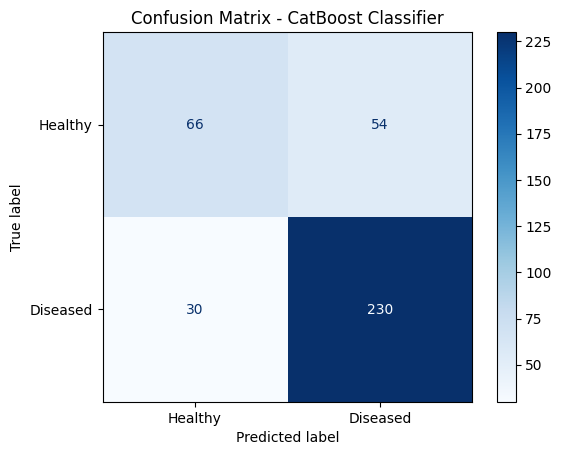

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Diseased"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost Classifier")
plt.show()
